# Spectre
*Total runtime: ~5 seconds*

---
In this notebook we'll go over how to load Spectre and use it to predict 1000 blue-side continua given a red-side spectrum. For this example, we'll be using SDSS J080556.12+120915.8.


The NSF code has been modified from Durkan et al. 2019 -- https://github.com/bayesiains/nsf.

In [1]:
import os
import sys
import time
import pickle
import torch
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../nsf')
from model import initialize_model

In [2]:
# Adjust default matplotlib parameters

sns.set_style('white')
sns.set_context('paper')

scale = 0.8
edge_color = '#463E3A'
blue_color = '#4682B4'
red_color = '#cd5c5c'

plt.rcParams['axes.edgecolor'] = edge_color
plt.rcParams['axes.labelcolor'] = edge_color
plt.rcParams['axes.titlecolor'] = edge_color
plt.rcParams['xtick.color'] = edge_color
plt.rcParams['ytick.color'] = edge_color
plt.rcParams['figure.dpi'] = 300.
plt.rcParams['figure.figsize'] = (scale*6, scale*6/1.618)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fancybox'] = True
plt.rcParams['legend.handlelength'] = 1.7
plt.rcParams['savefig.pad_inches'] = 0.05

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We now load Spectre's hyperparameters, sklearn pre-processing scaler, and the model itself. 

The scaler is `sklearn.preprocessing.StandardScaler()` fit to our training data so we load it here to maintain consistent data transformations with our test set. It transforms spectra into their flux z-scores on a pixelwise basis.

In [4]:
EXP_DIR = '../model'
DATA_DIR = '../data'

class Args:
    pass

args = Args()

with open(os.path.join(EXP_DIR, 'args.txt'), 'rb') as f:
    args.__dict__ = pickle.load(f)
    
with open(os.path.join(EXP_DIR, 'scaler.pkl'), 'rb') as f:
    scaler = pickle.load(f)

Let's now load a test spectrum and its associated wavelength bins. 

We subsample by a factor of 3 and split the spectrum into blue- and red-side at 1290Å.

In [5]:
spec_lim = [1191.5, 2900.]  # range of spectra wavelengths
plot_lim = [1191.5, 1400.]  # range of wavelengths in plots

In [6]:
example = np.load(os.path.join(DATA_DIR, 'example_spec.npz'))
cont, flux, wave, name = example['cont'], example['flux'], example['wave'], example['name']

cont = cont[(wave >= spec_lim[0]) & (wave < spec_lim[1])]
flux = flux[(wave >= spec_lim[0]) & (wave < spec_lim[1])]
wave = wave[(wave >= spec_lim[0]) & (wave < spec_lim[1])]
cont, flux, wave = cont[::args.subsample], flux[::args.subsample], wave[::args.subsample]

wavelength_cutoff = int(np.sum(wave < args.wavelength_threshold))
blue, red = cont[:wavelength_cutoff], cont[wavelength_cutoff:]

Let's take a look at the spectrum we're using.

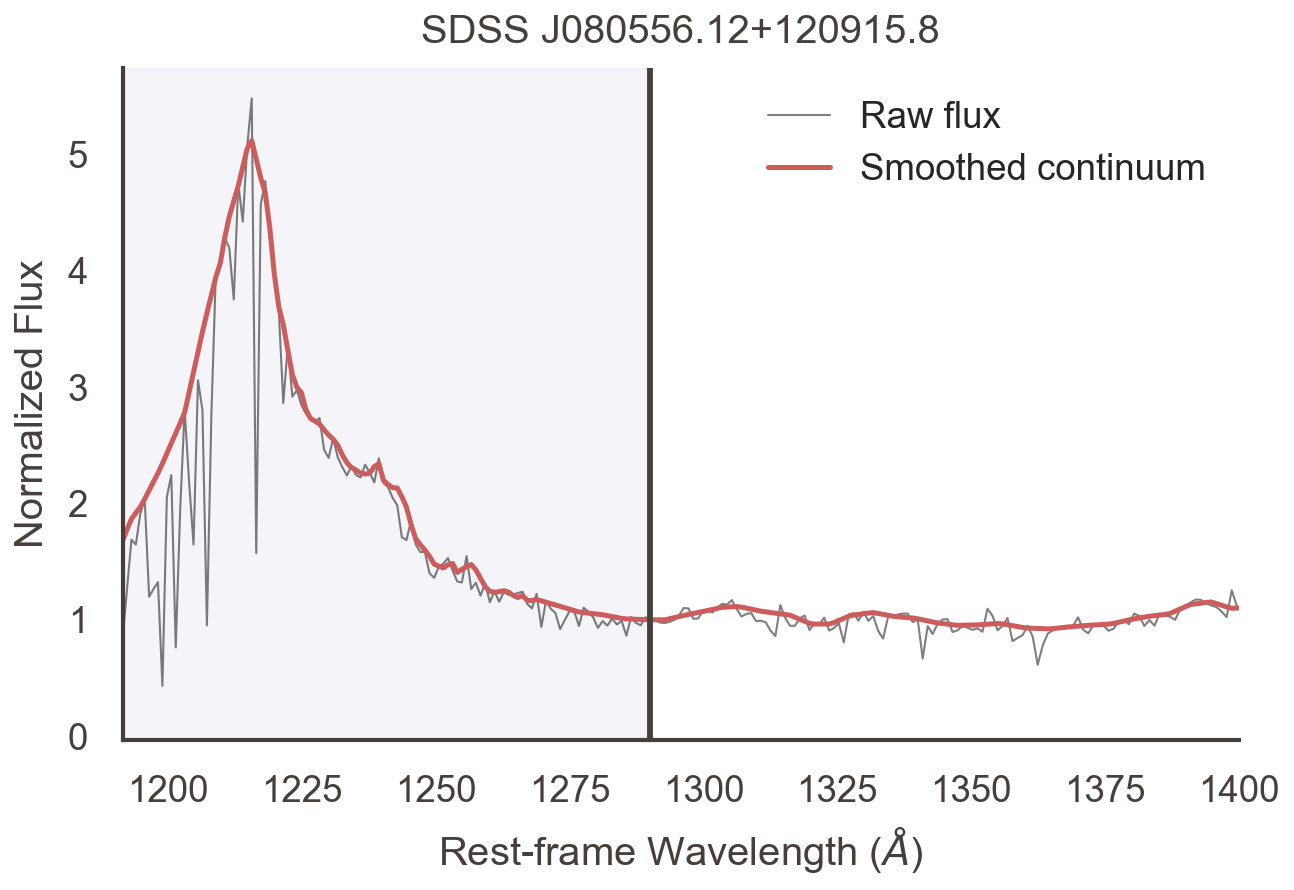

In [7]:
plt.plot(wave, flux, color='k', linewidth=0.5, alpha=0.5, label='Raw flux')
plt.plot(wave, cont, color=red_color, label='Smoothed continuum')
# Split red and blue side
plt.axvspan(1191.5, args.wavelength_threshold, color="#EAEAF4", alpha=0.5)
plt.axvline(args.wavelength_threshold, color=edge_color, linewidth=1.4)
plt.xlim(*plot_lim)
plt.xlabel(r'Rest-frame Wavelength ($\AA$)')
plt.ylabel('Normalized Flux')
plt.title(name)
sns.despine()
plt.legend()
plt.show()

We are now ready to sample from Spectre! Even on a CPU, sampling is fast. We can generate one thousand blue-side predictions in less than a second.

We'll load the model, take 1000 samples, then plot the results.

In [8]:
model = initialize_model(len(blue), len(red), args, device)
# Load in trained parameters
model.load_state_dict(torch.load(os.path.join(EXP_DIR, 'spectre_state_dict.pt')))
model = model.to(device)
model.eval()
None

In [9]:
def invert_samples(samples):
    """
    Samples generated by Spectre looked like scaled spectra, so this function
    inverts the z-score transformation. 
    
    Attach zeros to the end of samples in order to use the standard scaler.
    We'll then drop the last elements. Every element is manipulated individually
    so this is fine to do.
    """
    samples = samples.detach().cpu().numpy()
    samples = np.hstack([samples, np.zeros((n_samples, len(red)))])
    samples = scaler.inverse_transform(samples)
    return samples[:, :len(blue)]

In [10]:
n_samples = 1000

with torch.no_grad():
    samples, _ = model.sample(torch.tensor(red).float().to(device), n_samples)
    samples = invert_samples(samples)

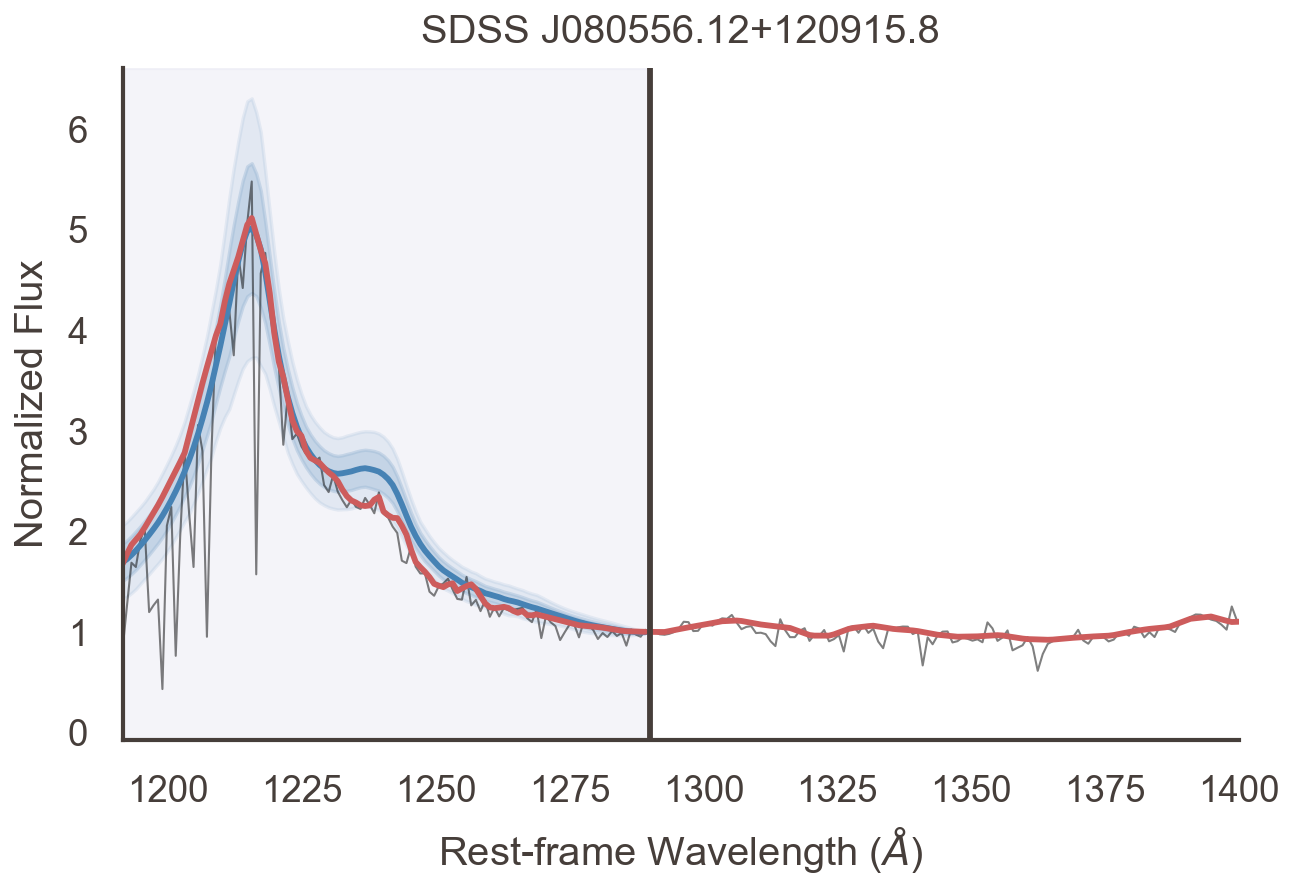

In [11]:
upper_limit = 1350
mean = samples.mean(0)
std = samples.std(0)
idx = sum(wave < upper_limit)

plt.plot(wave, flux, color='k', linewidth=0.5, alpha=0.5, label='Raw flux')
plt.plot(wave[wavelength_cutoff:wavelength_cutoff+idx], red[:idx], linewidth=1.4, color=red_color)
plt.plot(wave[:wavelength_cutoff], mean, linewidth=1.4, color=blue_color, label='Spectre')
plt.plot(wave[:wavelength_cutoff], blue, linewidth=1.4, color=red_color)
plt.fill_between(wave[:wavelength_cutoff], mean - 2*std, mean + 2*std, color=blue_color, alpha=0.2)
plt.fill_between(wave[:wavelength_cutoff], mean - std, mean + std, color=blue_color, alpha=0.4)

# Split red and blue side
plt.axvspan(1191.5, args.wavelength_threshold, color="#EAEAF4", alpha=0.5)
plt.axvline(args.wavelength_threshold, color=edge_color, linewidth=1.4)

plt.xlim(*plot_lim)
plt.xlabel(r'Rest-frame Wavelength ($\AA$)')
plt.ylabel('Normalized Flux')
plt.title(name)
sns.despine()